In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import *
from pyspark.sql.functions import split,col
from pyspark.sql.types import Row
from pyspark.sql.types import *
import json
from pyspark.sql.context import SQLContext
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans

In [2]:
spark = SparkSession.builder.appName("Tweet analysis").getOrCreate()

text_schema = StructType([StructField('text', StringType(), True)])
json_schema = MapType(StringType(), StringType())

tweet_df= spark \
    .readStream \
    .format("socket")\
    .option("host", "localhost") \
    .option("port",6100) \
    .load()
tweet_df.printSchema()
tweet_df1= tweet_df.selectExpr("CAST(value AS STRING)")

tweetdf2=tweet_df1.withColumn('json',from_json(col('value'),json_schema)).select(explode(col('json')))
tweetdf3=tweetdf2.withColumn('value',from_json(col('value'),json_schema)).withColumn('feature0',col('value.feature0')).withColumn('feature1',col('value.feature1')).drop('value')
tweetdf3.printSchema()

21/12/06 11:47:04 WARN Utils: Your hostname, pes1ug19cs384-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
21/12/06 11:47:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/06 11:47:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/06 11:47:09 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


root
 |-- value: string (nullable = true)

root
 |-- key: string (nullable = false)
 |-- feature0: string (nullable = true)
 |-- feature1: string (nullable = true)



In [3]:
def pre_process(tdf):
    tdf = tdf.na.replace('', None)
    tdf = tdf.na.drop()       
    tdf = tdf.withColumn('feature1', regexp_replace('feature1',r'@\w+',''))
    tdf = tdf.withColumn('feature1', regexp_replace('feature1','[^A-Za-z0-9\s]',''))
    tdf = tdf.withColumn('feature1', regexp_replace('feature1',r'http\S+',''))
    return tdf

In [4]:
batch_size = [1000,3000,5000,7000,9000,11000]
acc_model1 = [0.7611203054906761, 0.7615185185185188]
acc_model2 = [0.762589416577071, 0.7672222222222222] 
pre_model1,pre_model2,rec_model1,rec_model2 = [],[],[],[]

In [25]:
num=0
model1 = SGDClassifier(loss='log')
model2 = PassiveAggressiveClassifier(C=0.5)
acc1, acc2, pre1, pre2,rec1,rec2 = [],[],[],[],[],[]

def p(b,id):    
    global num
    num+=1
    df = pre_process(b)
    arr = [row['feature1'] for row in df.collect()]
    tar = [row['feature0'] for row in df.collect()]
    vectorizer = HashingVectorizer(n_features=2**15)
    x=None
    if arr:
        x = vectorizer.transform(arr)
        if num<=138:
            model1.partial_fit(x,tar,classes=['0','4'])
            model2.partial_fit(x,tar,classes=['0','4'])
        else:
            y_pred1 = model1.predict(x)
            y_pred2 = model2.predict(x)
            tn1, fp1, fn1, tp1 = confusion_matrix(tar,y_pred1).ravel()
            tn2, fp2, fn2, tp2 = confusion_matrix(tar,y_pred2).ravel()
            acc1.append((tn1+tp1)/(tp1+tn1+fn1+fp1))
            acc2.append((tn2+tp2)/(tp2+tn2+fn2+fp2))
            pre1.append(tp1/(tp1+fp1))
            pre2.append(tp2/(tp2+fp2))
            rec1.append(tp1/(tp1+fn1))
            rec2.append(tp2/(tp2+fn2))

query = tweetdf3.writeStream.foreachBatch(p).start()
query.awaitTermination()

21/12/06 12:58:48 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-2d55d968-334c-49e8-85b6-df0d27cde899. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
21/12/06 12:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
21/12/06 12:58:52 WARN TaskSetManager: Stage 1468 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 12:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
21/12/06 12:58:52 WARN TaskSetManager: Stage 1469 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 12:58:57 WARN DAGScheduler: Broadcasting large task binary with size 1288.2 KiB
21/12/06 12:58:57 WARN TaskSetManager: Stage 1470 contains 

21/12/06 13:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
21/12/06 13:00:18 WARN TaskSetManager: Stage 1502 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB
21/12/06 13:00:18 WARN TaskSetManager: Stage 1503 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB
21/12/06 13:00:23 WARN TaskSetManager: Stage 1504 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB
21/12/06 13:00:23 WARN TaskSetManager: Stage 1505 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:00:28 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:01:49 WARN DAGScheduler: Broadcasting large task binary with size 1286.9 KiB
21/12/06 13:01:49 WARN TaskSetManager: Stage 1538 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:01:49 WARN DAGScheduler: Broadcasting large task binary with size 1286.9 KiB
21/12/06 13:01:49 WARN TaskSetManager: Stage 1539 contains a task of very large size (1256 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1283.7 KiB
21/12/06 13:01:54 WARN TaskSetManager: Stage 1540 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1283.7 KiB
21/12/06 13:01:54 WARN TaskSetManager: Stage 1541 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:01:59 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:03:20 WARN DAGScheduler: Broadcasting large task binary with size 1286.3 KiB
21/12/06 13:03:20 WARN TaskSetManager: Stage 1574 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:03:20 WARN DAGScheduler: Broadcasting large task binary with size 1286.3 KiB
21/12/06 13:03:20 WARN TaskSetManager: Stage 1575 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1292.1 KiB
21/12/06 13:03:25 WARN TaskSetManager: Stage 1576 contains a task of very large size (1261 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1292.1 KiB
21/12/06 13:03:25 WARN TaskSetManager: Stage 1577 contains a task of very large size (1261 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:03:30 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1277.4 KiB
21/12/06 13:04:51 WARN TaskSetManager: Stage 1610 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1277.4 KiB
21/12/06 13:04:51 WARN TaskSetManager: Stage 1611 contains a task of very large size (1246 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1281.3 KiB
21/12/06 13:04:56 WARN TaskSetManager: Stage 1612 contains a task of very large size (1250 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1281.3 KiB
21/12/06 13:04:56 WARN TaskSetManager: Stage 1613 contains a task of very large size (1250 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:05:01 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:06:22 WARN DAGScheduler: Broadcasting large task binary with size 1286.1 KiB
21/12/06 13:06:22 WARN TaskSetManager: Stage 1646 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:06:22 WARN DAGScheduler: Broadcasting large task binary with size 1286.1 KiB
21/12/06 13:06:22 WARN TaskSetManager: Stage 1647 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
21/12/06 13:06:27 WARN TaskSetManager: Stage 1648 contains a task of very large size (1259 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
21/12/06 13:06:27 WARN TaskSetManager: Stage 1649 contains a task of very large size (1259 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:06:32 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:07:53 WARN DAGScheduler: Broadcasting large task binary with size 1274.0 KiB
21/12/06 13:07:53 WARN TaskSetManager: Stage 1682 contains a task of very large size (1243 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:07:53 WARN DAGScheduler: Broadcasting large task binary with size 1274.0 KiB
21/12/06 13:07:53 WARN TaskSetManager: Stage 1683 contains a task of very large size (1243 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1286.2 KiB
21/12/06 13:07:58 WARN TaskSetManager: Stage 1684 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1286.2 KiB
21/12/06 13:07:58 WARN TaskSetManager: Stage 1685 contains a task of very large size (1255 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:08:03 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:09:24 WARN DAGScheduler: Broadcasting large task binary with size 1284.2 KiB
21/12/06 13:09:24 WARN TaskSetManager: Stage 1718 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:09:24 WARN DAGScheduler: Broadcasting large task binary with size 1284.2 KiB
21/12/06 13:09:24 WARN TaskSetManager: Stage 1719 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:09:29 WARN DAGScheduler: Broadcasting large task binary with size 1284.5 KiB
21/12/06 13:09:29 WARN TaskSetManager: Stage 1720 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:09:29 WARN DAGScheduler: Broadcasting large task binary with size 1284.5 KiB
21/12/06 13:09:29 WARN TaskSetManager: Stage 1721 contains a task of very large size (1253 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:09:34 WARN DAGScheduler: Broadcasting large task binary 

21/12/06 13:10:56 WARN TaskSetManager: Stage 1753 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1285.0 KiB
21/12/06 13:11:00 WARN TaskSetManager: Stage 1754 contains a task of very large size (1254 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1285.0 KiB
21/12/06 13:11:01 WARN TaskSetManager: Stage 1755 contains a task of very large size (1254 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1282.8 KiB
21/12/06 13:11:06 WARN TaskSetManager: Stage 1756 contains a task of very large size (1252 KiB). The maximum recommended task size is 1000 KiB.
21/12/06 13:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1282.8 KiB
21/12/06 13:11:06 WARN TaskSetManager: Stage 1757 contains a task of

KeyboardInterrupt: 

In [26]:
s1,s2,s3,s4,s5,s6 = 0,0,0,0,0,0
for i in range(len(acc1)):
    s1 += acc1[i]
    s2 += acc2[i]
    s3 += pre1[i]
    s4 += pre2[i]
    s5 += rec1[i]
    s6 += rec2[i]
    
acc_model1.append(s1/len(acc1))
acc_model2.append(s2/len(acc1))
pre_model1.append(s3/len(acc1))
pre_model2.append(s4/len(acc1))
rec_model1.append(s5/len(acc2))
rec_model2.append(s6/len(acc1))
print(acc_model1)
print(acc_model2)
print(pre_model1)
print(pre_model2)
print(rec_model1)
print(rec_model2)

[0.7611203054906761, 0.7615185185185188, 0.7607853994328276, 0.7607857142857144, 0.7618518518518519, 0.7605568181818183]
[0.762589416577071, 0.7672222222222222, 0.7675972700422438, 0.7555000000000001, 0.765074074074074, 0.7701477272727273]
[0.75080069242965, 0.7505143594922647, 0.7538175150305515, 0.748670064543205]
[0.7593790555127204, 0.7140689607836544, 0.7715452389910149, 0.782229835989548]
[0.7761832689471054, 0.7763290921255855, 0.7743502183384681, 0.779342752272259]
[0.7792113555546772, 0.8466380353280908, 0.7499880508206438, 0.7442740167185814]


In [23]:
t = [126,43,25,18,14,11]

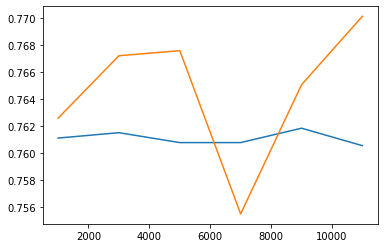

In [27]:
import matplotlib.pyplot as plt

plt.plot(batch_size,acc_model1,batch_size,acc_model2)
plt.show()

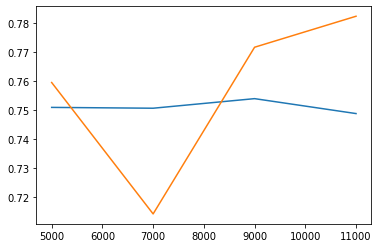

In [28]:
plt.plot(batch_size[2:],pre_model1,batch_size[2:],pre_model2)
plt.show()